In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('housing.csv')

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


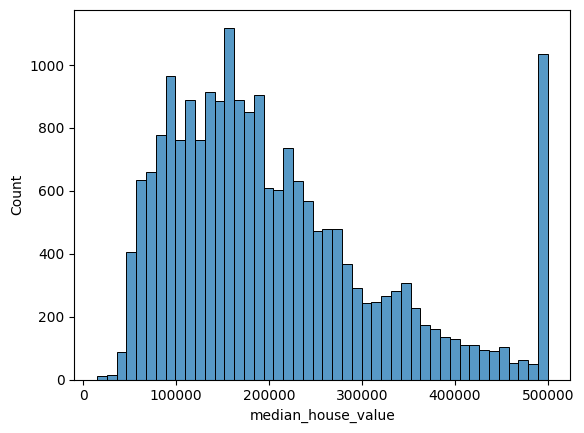

In [4]:
sns.histplot(df['median_house_value']);

In [5]:
features = ['latitude', 'longitude', 'housing_median_age','total_rooms',
'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

In [6]:
df_house = df[features]

## Question 1
Find a feature with missing values. How many missing values does it have?

In [7]:
df_house.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

## Question 2

What's the median (50% percentile) for variable 'population'?


In [8]:
df_house['population'].median()

1166.0

## Split data

-   Shuffle the initial dataset, use seed 42.
-   Split your data in train/val/test sets, with 60%/20%/20% distribution.
-   Make sure that the target value ('median_house_value') is not in your dataframe.
-   Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [9]:
## Splitting data into train, val, test following the 60/20/20 split
n = len(df_house)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test


## Shuffle the data
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)
df_train = df_house.iloc[idx[:n_train]]
df_val = df_house.iloc[idx[n_train:n_train+n_val]]
df_test = df_house.iloc[idx[n_train+n_val:]]


In [10]:
## Reset the index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [11]:
## Applying the log transformation to the target variable
y_train = np.log1p(df_train['median_house_value'].values)
y_val = np.log1p(df_val['median_house_value'].values)
y_test = np.log1p(df_test['median_house_value'].values)

In [12]:
## Drop the target variable from the data
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']


## Question 3
-   We need to deal with missing values for the column from Q1.
-   We have two options: fill it with 0 or with the mean of this variable.
-   Try both options. For each, train a linear regression model without regularization using the code from the lessons.
-   For computing the mean, use the training only!
-   Use the validation dataset to evaluate the models and compare the RMSE of each option.
-   Round the RMSE scores to 2 decimal digits using round(score, 2)
-   Which option gives better RMSE?

Options:

With 0

With mean

Both are equally good

In [16]:
## Function to calculate the linear regression
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

## Function to calculate RMSE
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return round(np.sqrt(mse),2)

In [20]:
## X_train_0: X values after filling the missing values with 0
## X_train_mean: X values after filling the missing values with the mean
X_train_0 = df_train.fillna(0).values
X_train_mean = df_train.fillna(df_train.mean()).values
## Training the model with X_train_0 and X_train_mean
w0_0, w_0 = train_linear_regression(X_train_0, y_train)
w0_mean, w_mean = train_linear_regression(X_train_mean, y_train)
## Predicting the values for the validation set
y_pred_0 = w0_0 + df_val.values.dot(w_0)
y_pred_mean = w0_mean + df_val.values.dot(w_mean)

print('RMSE using 0: ', rmse(y_val, y_pred_0))
print('RMSE using mean: ', rmse(y_val, y_pred_mean))

RMSE using 0:  0.33
RMSE using mean:  0.33


In [21]:
## With Regularization
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

Options:
- 0
- 0.000001
- 0.001
- 0.0001


In [22]:
r_values = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

for r in r_values:
    w0, w = train_linear_regression_reg(X_train_mean, y_train, r=r)
    y_pred = w0 + df_val.values.dot(w)
    print('RMSE with r = {}: {}'.format(r, rmse(y_val, y_pred)))

RMSE with r = 0: 0.33
RMSE with r = 1e-06: 0.33
RMSE with r = 0.0001: 0.33
RMSE with r = 0.001: 0.33
RMSE with r = 0.01: 0.33
RMSE with r = 0.1: 0.33
RMSE with r = 1: 0.33
RMSE with r = 5: 0.34
RMSE with r = 10: 0.34


### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

Options:
- 0.16
- 0.00005
- 0.005
- 0.15555

In [24]:
rmse_values = []
for i in range(0,10):
    n = len(df_house)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test
    ## Shuffle the data
    idx = np.arange(n)
    np.random.seed(i)
    np.random.shuffle(idx)
    df_train = df_house.iloc[idx[:n_train]]
    df_val = df_house.iloc[idx[n_train:n_train+n_val]]
    df_test = df_house.iloc[idx[n_train+n_val:]]

    ## Reset the index
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    ## Applying the log transformation to the target variable
    y_train = np.log1p(df_train['median_house_value'].values)
    y_val = np.log1p(df_val['median_house_value'].values)
    y_test = np.log1p(df_test['median_house_value'].values)
    ## Drop the target variable from the data
    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    ## Fill the missing values with 0
    X_train = df_train.fillna(0).values
    X_val = df_val.fillna(0).values
    X_test = df_test.fillna(0).values
    ## Training the model
    w0, w = train_linear_regression_reg(X_train, y_train, r=0.001)
    y_pred = w0 + X_val.dot(w)
    print('RMSE with seed= {}: {}'.format(i, rmse(y_val, y_pred)))
    rmse_values.append(rmse(y_val, y_pred))
## Standard desviation of the RMSE values
print('Standard desviation of the RMSE values: ', round(np.std(rmse_values),3))

RMSE with seed= 0: 0.34
RMSE with seed= 1: 0.34
RMSE with seed= 2: 0.33
RMSE with seed= 3: 0.34
RMSE with seed= 4: 0.34
RMSE with seed= 5: 0.34
RMSE with seed= 6: 0.35
RMSE with seed= 7: 0.34
RMSE with seed= 8: 0.35
RMSE with seed= 9: 0.34
Standard desviation of the RMSE values:  0.005


### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

Options:
- 0.35
- 0.135
- 0.450
- 0.245

In [26]:
n = len(df_house)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test
## Shuffle the data
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)
df_train = df_house.iloc[idx[:n_train]]
df_val = df_house.iloc[idx[n_train:n_train+n_val]]
df_test = df_house.iloc[idx[n_train+n_val:]]

## Reset the index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
## Applying the log transformation to the target variable
y_train = np.log1p(df_train['median_house_value'].values)
y_val = np.log1p(df_val['median_house_value'].values)
y_test = np.log1p(df_test['median_house_value'].values)
## Drop the target variable from the data
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']
## Fill the missing values with 0
X_train = df_train.fillna(0).values
X_val = df_val.fillna(0).values
X_test = df_test.fillna(0).values
## Combine X_train and X_val
X_train = np.concatenate((X_train, X_val), axis=0)
y_train = np.concatenate((y_train, y_val), axis=0)
## Training the model
w0, w = train_linear_regression_reg(X_train, y_train, r=0.001)
y_pred = w0 + X_test.dot(w)
print('RMSE with seed=9: {}'.format(rmse(y_test, y_pred)))
rmse_values.append(rmse(y_val, y_pred))

RMSE with seed=9: 0.35
